# Problem statement

An optimisation of ambulance deployment strategy in a big city with a chaotic traffic is a complex task which can’t be resolved with a simple optimization algorithms. This problem require a multipronged approach that could take in account complex of factors, such as weather, average speed of traffic, time of day and quality of roads. 
When it comes to emergency response to road accidents, every second counts. Finding the best location to position emergency should reduce the amount of lethal outcomes of car accidents. It is also essential due to the terrifying statistics: road traffic collisions are the number one killer of children and young adults ages 5-29.
Besides, optimizing emergency positions leads to saving money on gasoline. This money can be used for hospital’s equipment improving. This will also lead to a reduction in fatalities.

# First approach


## Data loading, preprocessing and EDA (part 1)

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

In [1]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


Firstly, let's convert 'datetime' column and append new features to our dataset:

In [3]:
df.datetime = pd.to_datetime(df.datetime)

In [4]:
df['month'] = df.datetime.dt.month
df['day'] = df.datetime.dt.day
df['weekday'] = df.datetime.dt.weekday
df['hour'] = df.datetime.dt.hour.astype(int)
df['year'] = df.datetime.dt.year.astype(int)

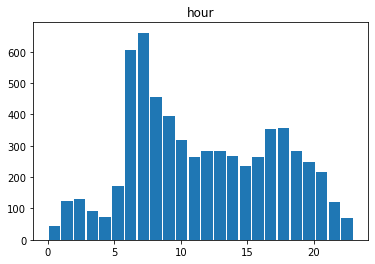

In [5]:
ax = df.hist(column='hour',bins=24, grid=False,rwidth=0.9)

From graph we see two peaks, one is 7:00 am, the other is 6:00 pm.

Now let's calculate an average amount of crashes at the particular time: from 0:00 to 3:00; from 3:00 to 6:00 and etc.. And let's create a column that identifies the particular period of time. 

In [6]:
def func(x):
    if x<3:
        return '0-3'
    elif x < 6:
        return '3-6'
    elif x<9:
        return '6-9'
    elif x <12:
        return '9-12'
    elif x < 15:
        return '12-15'
    elif x< 18:
        return '15-18'
    elif x<21:
        return '18-21'
    else:
        return '21-24'

In [7]:
df['time_period'] = df['hour'].apply(lambda x: func(x))

In [8]:
freq = df.groupby('time_period')['uid'].count()/546 #546 is a number of days we analyze
freq

time_period
0-3      0.542125
12-15    1.527473
15-18    1.562271
18-21    1.626374
21-24    0.745421
3-6      0.622711
6-9      3.157509
9-12     1.787546
Name: uid, dtype: float64

From that table we can see that crashes from 6:00 till 9:00 happen the most frequently. The second place takes the period from 9:00 till 12:00 and the third -  from 18:00 till 21:00.

In [9]:
df['freq_hour'] = df.time_period.apply(lambda x: freq[freq.index == x][0])

In [10]:
freq_week = df.groupby('weekday')['uid'].count()/78 #78 is a number of weeks we analyze
freq_week

weekday
0    11.115385
1    13.858974
2    13.141026
3    11.307692
4    12.884615
5    10.884615
6     7.807692
Name: uid, dtype: float64

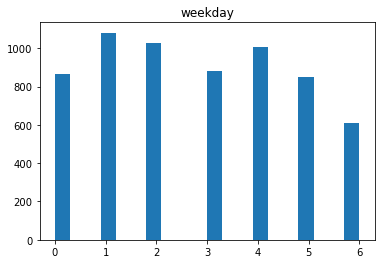

In [11]:
ax = df.hist(column='weekday',bins=20, grid=False,rwidth=4)

From that table and graph we can see that the most frequently crashes happen on Tue and Wed.

In [12]:
df['freq_weekday'] = df['weekday'].apply(lambda x: freq_week[freq_week.index == x].values[0])

Let's look at how number of crashes depends from month.

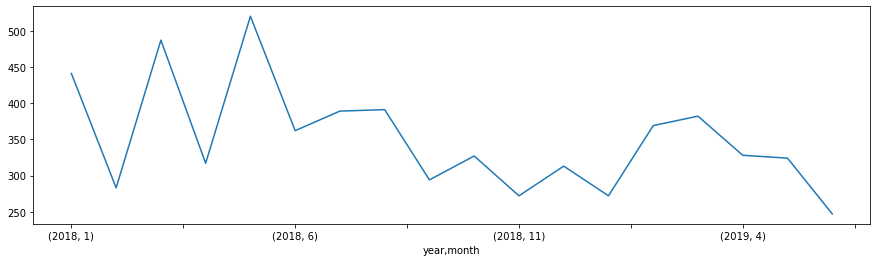

In [13]:
fig, axes = plt.subplots(figsize=(15,4), sharey=True)
df.groupby(['year','month'])['uid'].count().plot(ax=axes)

Let's look how number of crashes depend from half a year.

[]

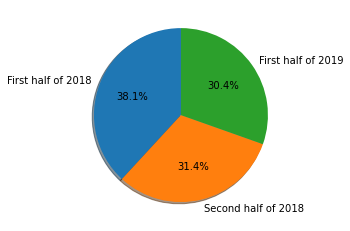

In [14]:
labels = ['First half of 2018', 'Second half of 2018', 'First half of 2019']
sizes = [df.loc[(df.year == 2018) &(df.month <= 6)].uid.count(),
        df.loc[(df.year == 2018) &(df.month > 6)].uid.count(),
        df.loc[(df.year == 2019) &(df.month <= 6)].uid.count()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.plot()

As we can see, there is no dependency between number of crashes half-year periods.

Now let's define a rectangle inside which crashes are located and plot the crashes:

In [15]:
df.longitude.min(), df.longitude.max()

(36.332201603768, 37.8794900011581)

In [16]:
df.latitude.min(),df.latitude.max()

(-3.05000000215335, -0.565402313796744)

The location of the crashes depending on the year:

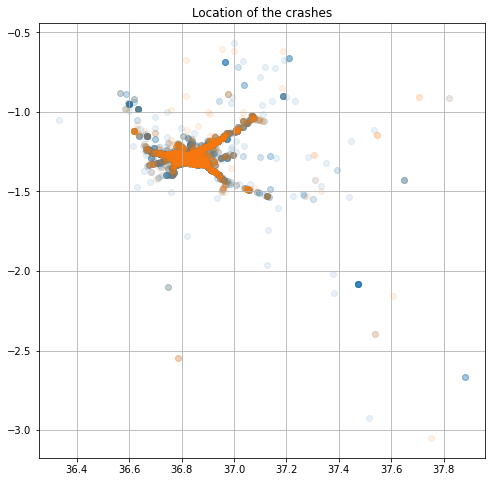

In [17]:
x_2018 = df.loc[(df.year == 2018)]['longitude']
y_2018 = df.loc[(df.year == 2018)]['latitude']
x_2019 = df.loc[(df.year == 2019)]['longitude']
y_2019 = df.loc[(df.year == 2019)]['latitude']
plt.figure(figsize=(8, 8))
plt.title('Location of the crashes')
plt.grid(True)
plt.scatter(x_2018,y_2018,alpha=0.1,c='tab:blue')
plt.scatter(x_2019,y_2019,alpha=0.1,c='tab:orange')
plt.show()

The location of the crashes during the first six months depending on the year:

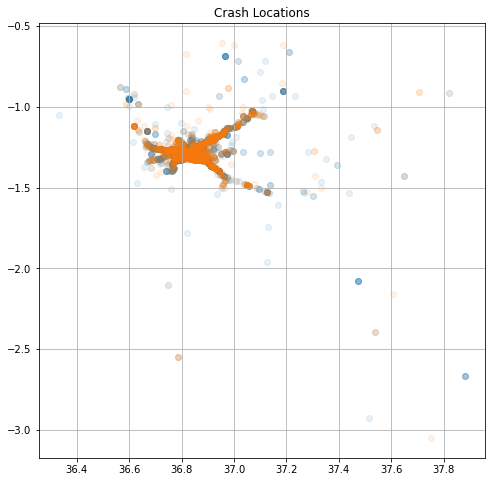

In [18]:
x_old = df.loc[(df.year == 2018) &(df.month <= 6)]['longitude']
y_old = df.loc[(df.year == 2018) &(df.month <= 6)]['latitude']
x_new = df.loc[(df.year == 2019) &(df.month <= 6)]['longitude']
y_new = df.loc[(df.year == 2019) &(df.month <= 6)]['latitude']
plt.figure(figsize=(8, 8))
plt.title('Crash Locations')
plt.grid(True)
plt.scatter(x_old,y_old,alpha=0.1,c='tab:blue')
plt.scatter(x_new,y_new,alpha=0.1,c='tab:orange')
plt.show()

According to the graphics above it can be seen that the places with the highest level of crashes are approximately the same in 2018 and 2019. And sometimes crashes happened in some unexpected places. Leter on we will exclude these sample points from our train set.

# Clustering model

###  Drop outliers and split the data into train and test 

In [19]:
df_clean = df[(df.longitude>36.6)&(df.longitude<37.2)&(df.latitude<-1)&(df.latitude>-1.6)] #only use points located in the centre

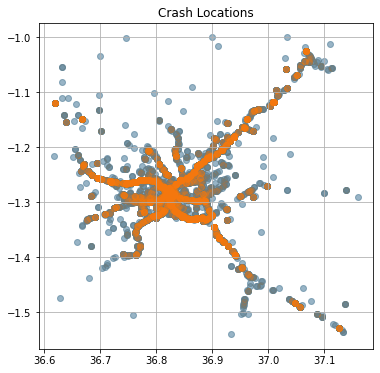

In [20]:
x = df_clean['longitude']
y = df_clean['latitude']
plt.figure(figsize=(6, 6))
plt.title('Crash Locations')
plt.grid(True)
plt.scatter(x,y,alpha=0.5,c='tab:blue')
plt.scatter(x,y,alpha=0.09,c='tab:orange')
plt.show()

In [21]:
train = df_clean[df_clean.year ==2018]
test = df_clean[df_clean.year ==2019]

As you can see we used information from 2018 year as train data and information from 2019 as test data. Let's take a look at the proportions according to which our data has been split:

In [22]:
train.shape[0]/df_clean.shape[0], test.shape[0]/df_clean.shape[0]

(0.6918043513823, 0.3081956486177)

### Building and training the models and choosing the best one

Our first approach for solving that problem is based on using clustering model. We decided to choose it because we do not have targets in our dataset and, therefore, we have to use unsupervised learning. The number of clusters is equal to 6 as we have six ambulances. We will compare three different algorithms from sklearn, they are KMeans, AgglomerativeClustering and SpectralClustering. To compare the performance of these algorithms we will use silhouette_score.

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import metrics

algorithms = []
algorithms.append(KMeans(n_clusters=6, random_state=42))
algorithms.append(SpectralClustering(n_clusters=6, random_state=42))
algorithms.append(AgglomerativeClustering(n_clusters=6))

data = []
for algo in algorithms:
    algo.fit(train[['latitude','longitude']])
    data.append(({
        'Silhouette on train': metrics.silhouette_score(train[['latitude','longitude']], algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette on train'], index=['K-means', 'Spectral', 'Agglomerative']) 

results

,Silhouette on train
K-means,0.433482
Spectral,0.354074
Agglomerative,0.392030


The silhouette shows how the average distance to objects in its own cluster differs from the average distance to objects in other clusters. Values close to -1 correspond to bad clustering, values close to zero indicate that clusters overlap, values close to 1 correspond to clearly defined clusters. Thus, the larger the silhouette, the more clearly the clusters are distinguished. 

The best algorithm according to this score is KMeans. Hence, we will use it to predict the locations of ambulances (they will be located in the center of the clusters). Moreover, other algorithms do not have cluster_centers_ attribute and it has to be calculated additionally in two stages (because of that the accuracy of the result might decrease). (The calculation of cluster centres can be done as follows: https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn).

### Predicting locations of ambulances

In [24]:
algorithm = KMeans(n_clusters=6, random_state=42)

data = []
algorithm.fit(train[['latitude','longitude']])
data.append(({
    'Silhouette_train': metrics.silhouette_score(train[['latitude','longitude']], algorithm.labels_),
    'Silhouette_test': metrics.silhouette_score(test[['latitude','longitude']], algorithm.predict(test[['latitude','longitude']]))
}))

results = pd.DataFrame(data=data, columns=['Silhouette_train', 'Silhouette_test'], index=['K-means']) 

results

,Silhouette_train,Silhouette_test
K-means,0.433482,0.417977


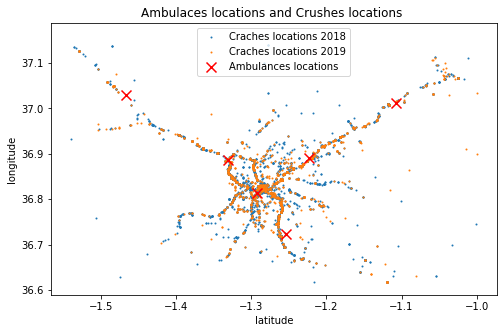

In [25]:
fig, axs = plt.subplots(figsize=(8, 5))


plt.scatter(x = train['latitude'],y=train['longitude'], s=1, label='Craches locations 2018' )
plt.scatter(x = test['latitude'],y=test['longitude'], s=1, label='Craches locations 2019' )

plt.scatter(x=algorithm.cluster_centers_[:,0], y=algorithm.cluster_centers_[:,1],marker="x",
            color='r',label='Ambulances locations',s=100)
axs.set_title('Ambulaces locations and Crushes locations ')
plt.xlabel('latitude')
plt.ylabel("longitude")
plt.legend()
plt.show()

In [26]:
#predicted locations of ambulances
algorithm.cluster_centers_

array([[-1.33127926, 36.88655549],
       [-1.10785636, 37.01297961],
       [-1.25426692, 36.7228221 ],
       [-1.22283731, 36.89021608],
       [-1.29244124, 36.81258553],
       [-1.46612233, 37.02927664]])

### Scoring

In [27]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [28]:
# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = algorithm.cluster_centers_[ambulance][0]
    sub['A'+str(ambulance)+'_Longitude'] = algorithm.cluster_centers_[ambulance][1]

round(score(sub, test),3)

72.833

### Creating the submission file 

In [29]:
#sub.to_csv('kmeans.csv')

 We made a submission on zindi.africa and got score equal to **41.600**.

# Second approach
## Data loading, preprocessing and EDA (part 2)

### Weather dataset analysis and preprocessing
Another dataset for this challenge (Weather_Nairobi_Daily_GFS.csv, Segment_info.csv) is a daily weather in Nairobi over 2018-19.

In [30]:
weather = pd.read_csv('Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
print(weather.shape)
weather.head()

(731, 7)


,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


Let's replace Nan values from weather dataframe with same values from other year.

In [31]:
weather[weather.isna().precipitable_water_entire_atmosphere == True]

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
74,2018-03-16,NaN,NaN,NaN,NaN,NaN,NaN
75,2018-03-17,NaN,NaN,NaN,NaN,NaN,NaN
76,2018-03-18,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
from datetime import date
d = {}
for j in weather.columns[1:]:
    l =[]
    for i in list(weather[weather.isna().precipitable_water_entire_atmosphere == True].Date):
        l.append(float(weather[weather.Date == i.replace(year = i.year + 1)][j]))
    d[j] = np.array(l).mean()
weather.fillna(value=d,inplace=True)    

Weather dataset contain weather from 2018-01-01 till 2020-01-01. Let's create dataset with weather till 2019-07-01 (weather_cr), because we have information about crashes till this date. And let's add to this dataset information about crashes per day.

In [33]:
weather_cr = weather[weather.Date < '2019-07-01'].copy(deep=True)
n_crashes = []
for i in range(weather_cr.shape[0]):
    if weather.Date.dt.date[i] in list(df.datetime.dt.date):
        n_crashes.append(int(pd.Series(df.datetime.dt.date).value_counts().loc[weather_cr.Date.dt.date[i]]))
    else: n_crashes.append(0)
weather_cr['crashes'] = n_crashes        

Let's add columns with wind, as we have u and v components. And let's look at correlation between features.

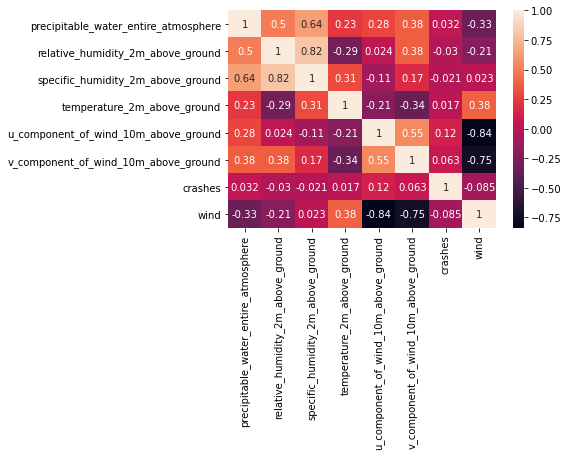

In [34]:
weather_cr['wind'] = weather_cr[['u_component_of_wind_10m_above_ground', 
                               'v_component_of_wind_10m_above_ground']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
sns.heatmap(weather_cr.corr(),annot = True)

We can see that number of crashes has a weak correlation with other features. 

### Creating targer values

Let's upload dataset Train.csv one more time and drop outliers from it:

In [35]:
df_origin = pd.read_csv('Train.csv', parse_dates=['datetime'])
df_2 = df_origin[(df_origin.longitude>36.6)&(df_origin.longitude<37.2)&(df_origin.latitude<-1)&(df_origin.latitude>-1.6)]

In [36]:
df_2['hour'] = df_2.datetime.apply(lambda x: x.hour)
df_2['day'] = df_2.datetime.apply(lambda x: x.day)
df_2['month'] = df_2.datetime.apply(lambda x: x.month)
df_2['year'] = df_2.datetime.apply(lambda x: x.year)
df_2['time_period'] = df_2['hour'].apply(lambda x: func(x))

To connect these two datasets let's create new columns in the dataframe weather_cr:

In [37]:
weather['day'] = weather.Date.apply(lambda x: x.day)
weather['month'] = weather.Date.apply(lambda x: x.month)
weather['year'] = weather.Date.apply(lambda x: x.year)

Let's create a sample **y_** that we will use later to train and validate our model:

In [38]:
dates = pd.date_range('2018-01-01', '2019-07-01', freq='3h')

y_ = pd.DataFrame({
    'date':dates[:-1]
})
for ambulance in range(6):
    y_['A'+str(ambulance)+'_Latitude'] = 0
    y_['A'+str(ambulance)+'_Longitude'] = 0

In [39]:
y_['hour'] = y_.date.apply(lambda x: x.hour)
y_['day'] = y_.date.apply(lambda x: x.day)
y_['month'] = y_.date.apply(lambda x: x.month)
y_['year'] = y_.date.apply(lambda x: x.year)
y_['time_period'] = y_['hour'].apply(lambda x: func(x))

For training this model we need to create target values - locations of ambulances. We will do it as follows:
- group our data by time periods (3 hours);
- place ambulances at the places where there are crashes (it turned out that the number of crashes usually is less then six).


If we have data gaps then:
 - when we have statistics for a given time period, we fill gaps with the median location in this time period (**y_fillna**);
 - when we have no data on this time period we fill gaps with the location of the city centre (**y_center**).

In [40]:
y_fillna = df_2.round({'latitude': 4, 'longitude': 4} \
        ).groupby(['month','day','time_period'])['latitude','longitude'].median().reset_index()

y_center = [-1.2870500556641022, 36.822] 

In [41]:
from tqdm import tqdm

In [42]:
for num_line,line in tqdm(enumerate(y_.iterrows())):
    row = line[1]
    # find crashes that took place at this year, month, day & time_period
    rigth_ex = df_2[(df_2['time_period']==row['time_period']) & (df_2['day']==row['day']) & (df_2['month']==row['month']) & (df_2['year']==row['year']) ]
    # sort by coordinates
    rigth_ex.sort_values(['longitude','latitude'],inplace=True)
    
    for ambulance in range(min(len(rigth_ex),6)):
        y_.loc[num_line,'A'+str(ambulance)+'_Latitude'] = rigth_ex['latitude'].iloc[ambulance]
        y_.loc[num_line,'A'+str(ambulance)+'_Longitude'] = rigth_ex['longitude'].iloc[ambulance]
    #fill the gaps with the median location in this time period
    if len(rigth_ex) < 6:
        rigth_fill = y_fillna[(y_fillna['time_period']==row['time_period']) & (y_fillna['day']==row['day']) & (y_fillna['month']==row['month']) ]
        if len(rigth_fill)>=1:
            for ambulance in range(len(rigth_ex),6):
                y_.loc[num_line,'A'+str(ambulance)+'_Latitude'] = rigth_fill['latitude'].iloc[0]
                y_.loc[num_line,'A'+str(ambulance)+'_Longitude'] = rigth_fill['longitude'].iloc[0]
    #fill gaps with the location of the city cenre
    for ambulance in range(0,6):
        if (y_.loc[num_line,'A'+str(ambulance)+'_Latitude'] == 0) & (y_.loc[num_line,'A'+str(ambulance)+'_Longitude'] == 0): 
            y_.loc[num_line,'A'+str(ambulance)+'_Latitude'] = y_center[0] 
            y_.loc[num_line,'A'+str(ambulance)+'_Longitude'] = y_center[1]

4368it [00:31, 136.89it/s]


Let's have a look at our final dataframe:

In [43]:
y_.head(5)

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude,hour,day,month,year,time_period
0,2018-01-01 00:00:00,-1.188850,36.931382,-1.188800,36.931400,-1.188800,36.931400,-1.188800,36.931400,-1.1888,36.9314,-1.1888,36.9314,0,1,1,2018,0-3
1,2018-01-01 03:00:00,-1.288087,36.826583,-1.188850,36.931382,-1.165228,36.960008,-1.188800,36.931400,-1.1888,36.9314,-1.1888,36.9314,3,1,1,2018,3-6
2,2018-01-01 06:00:00,-1.301303,36.820903,-1.301300,36.820900,-1.301300,36.820900,-1.301300,36.820900,-1.3013,36.8209,-1.3013,36.8209,6,1,1,2018,6-9
3,2018-01-01 09:00:00,-1.282547,36.827234,-1.272261,36.828107,-1.134640,36.848220,-1.117207,37.008278,-1.2723,36.8281,-1.2723,36.8281,9,1,1,2018,9-12
4,2018-01-01 12:00:00,-1.316200,36.895700,-1.316200,36.895700,-1.316200,36.895700,-1.316200,36.895700,-1.3162,36.8957,-1.3162,36.8957,12,1,1,2018,12-15


Let's check if we have zeros in our dataframe after data preprocessing:

In [44]:
y_[(y_[['A0_Latitude','A1_Latitude','A2_Latitude','A3_Latitude','A4_Latitude','A5_Latitude']]==0).any(axis=1)]

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude,hour,day,month,year,time_period


There is none of them.

### Adding new features

Let's add new feature that will represent mean values of latitude and longitude:

In [45]:
y_fillna_mean = df_2.round({'latitude': 4, 'longitude': 4} \
        ).groupby(['month','day','time_period'])['latitude','longitude'].mean().reset_index()
y_fillna_mean.head()

,month,day,time_period,latitude,longitude
0,1,1,0-3,-1.188800,36.9314
1,1,1,12-15,-1.316200,36.8957
2,1,1,3-6,-1.214033,36.9060
3,1,1,6-9,-1.301300,36.8209
4,1,1,9-12,-1.221040,36.8636


In [46]:
y_fillna_mean.rename(columns={'latitude': 'latitude_m_d', 'longitude': 'longitude_m_d'}, inplace=True)

We created that new feature in another dataframe, so now we need to add it to our main dataframe.

### Merging all our dataframes

In [47]:
data_all = pd.merge(y_,y_fillna_mean,how='left',on=['day', 'month', 'time_period'])
data_all.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude,hour,day,month,year,time_period,latitude_m_d,longitude_m_d
0,2018-01-01 00:00:00,-1.188850,36.931382,-1.188800,36.931400,-1.188800,36.931400,-1.188800,36.931400,-1.1888,36.9314,-1.1888,36.9314,0,1,1,2018,0-3,-1.188800,36.9314
1,2018-01-01 03:00:00,-1.288087,36.826583,-1.188850,36.931382,-1.165228,36.960008,-1.188800,36.931400,-1.1888,36.9314,-1.1888,36.9314,3,1,1,2018,3-6,-1.214033,36.9060
2,2018-01-01 06:00:00,-1.301303,36.820903,-1.301300,36.820900,-1.301300,36.820900,-1.301300,36.820900,-1.3013,36.8209,-1.3013,36.8209,6,1,1,2018,6-9,-1.301300,36.8209
3,2018-01-01 09:00:00,-1.282547,36.827234,-1.272261,36.828107,-1.134640,36.848220,-1.117207,37.008278,-1.2723,36.8281,-1.2723,36.8281,9,1,1,2018,9-12,-1.221040,36.8636
4,2018-01-01 12:00:00,-1.316200,36.895700,-1.316200,36.895700,-1.316200,36.895700,-1.316200,36.895700,-1.3162,36.8957,-1.3162,36.8957,12,1,1,2018,12-15,-1.316200,36.8957


Let's also merge our main dataset with weather:

In [48]:
data_all = pd.merge(data_all,weather.drop(['Date'],axis=1),how='left',on=['day', 'month','year'])

### Correlation between features 

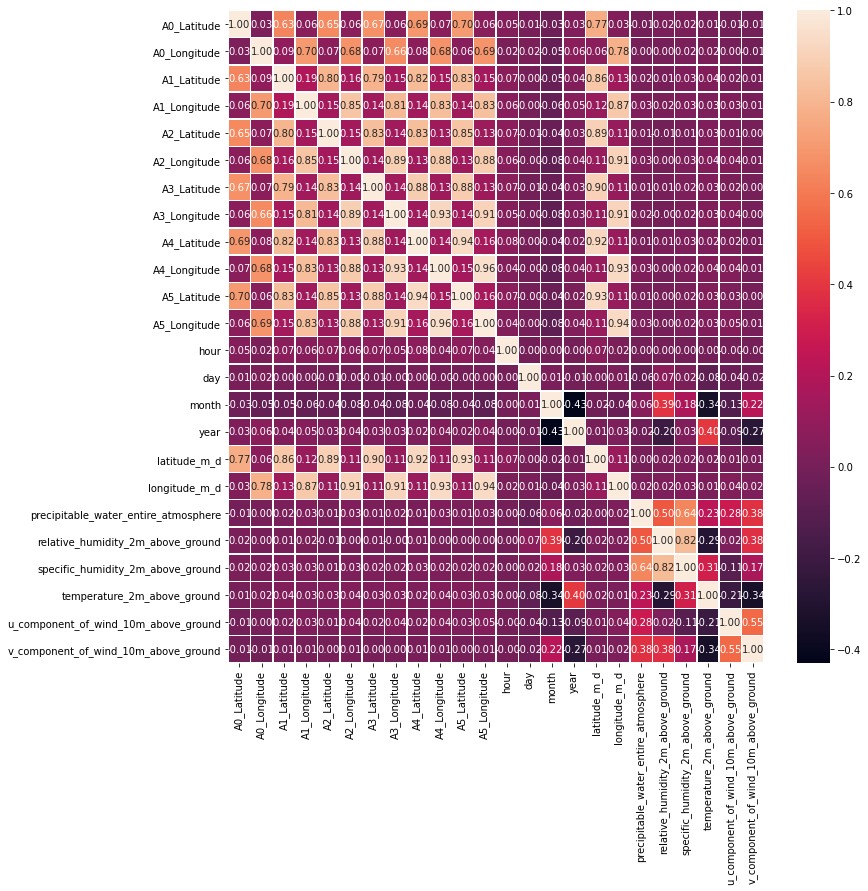

In [49]:
plt.figure(figsize=(12,12))
sns.heatmap(data_all.corr(), annot = True, fmt = '.2f',linewidths=.5)

### Final preprocessing (replacing NaNs and making OHE on categorical features)

In [50]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  4368 non-null   datetime64[ns]
 1   A0_Latitude                           4368 non-null   float64       
 2   A0_Longitude                          4368 non-null   float64       
 3   A1_Latitude                           4368 non-null   float64       
 4   A1_Longitude                          4368 non-null   float64       
 5   A2_Latitude                           4368 non-null   float64       
 6   A2_Longitude                          4368 non-null   float64       
 7   A3_Latitude                           4368 non-null   float64       
 8   A3_Longitude                          4368 non-null   float64       
 9   A4_Latitude                           4368 non-null   float64       
 10  

As it can be seen there are NaN values in latitude_m_d and longitude_m_d. Let's fill them with median value of these features:

In [51]:
data_all['latitude_m_d'] = data_all['latitude_m_d'].fillna(value=data_all['latitude_m_d'].median())
data_all['longitude_m_d'] = data_all['longitude_m_d'].fillna(value=data_all['longitude_m_d'].median())

One hot encoding on categorical feature:

In [52]:
data_all = data_all.join(pd.get_dummies(data_all['time_period']))
data_all.drop(['time_period'],axis=1,inplace=True)

### Splitting our data into Train and Test

In [53]:
train = data_all[data_all.year ==2018]
test = data_all[data_all.year ==2019]

In [54]:
X_train = train[train.columns[14:]]
y_train = train[train.columns[1:13]]

X_test = test[test.columns[14:]]
y_test = test[test.columns[1:13]]

### Feature Importance

We will choose top-10 features according to the RandomForestRegressor.

In [55]:
from sklearn.ensemble import RandomForestRegressor

reference = df.loc[df.datetime > '2019-01-01']
random_forest = RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)
random_forest.fit(X_train, y_train)

importances = random_forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [56]:
y_pred = random_forest.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

118.05477035171691

Feature ranking:
1. feature longitude_m_d (0.502373)
2. feature latitude_m_d (0.413111)
3. feature u_component_of_wind_10m_above_ground (0.013464)
4. feature temperature_2m_above_ground (0.010936)
5. feature day (0.009386)
6. feature v_component_of_wind_10m_above_ground (0.009114)
7. feature relative_humidity_2m_above_ground (0.008999)
8. feature precipitable_water_entire_atmosphere (0.007876)
9. feature specific_humidity_2m_above_ground (0.007420)
10. feature month (0.005967)


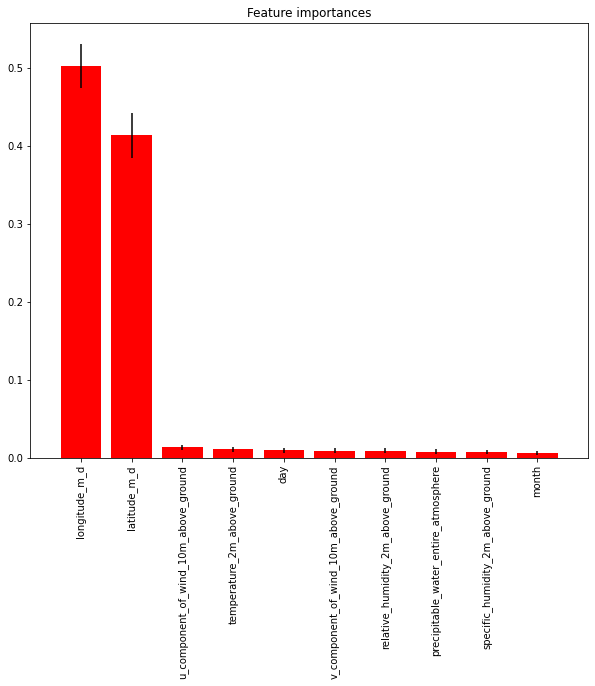

In [57]:
print("Feature ranking:")

num_feats = 10

names_hor = []
for f in range(num_feats):#X.shape[1]
    print("%d. feature %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))
    names_hor.append(X_train.columns.values[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(10,8))
plt.title("Feature importances")
plt.bar(range(num_feats), importances[indices[:num_feats]],
       color="r", yerr=std[indices[:num_feats]], align="center") 
plt.xticks(range(num_feats), names_hor,rotation='vertical')
plt.xlim([-1, num_feats])
plt.show()

## Multilabel Regression model

In our second approach we decided to use all the features we generated because there are not much of them. 

### GridSearch

In [58]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

In [59]:
pipe_rf = Pipeline([
        ('reg', RandomForestRegressor(random_state=42,n_jobs=-1))])

grid_param_rf = {
    'reg__n_estimators': np.arange(50,201,50),
    'reg__max_depth': np.arange(10,51,20),
}

gs_rf = (GridSearchCV(estimator=pipe_rf, 
                      param_grid=grid_param_rf, 
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_rf = gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_)

Pipeline(steps=[('reg',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       n_jobs=-1, random_state=42))])


In [60]:
y_pred = gs_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

118.05477035171684

In [61]:
pipe_rf = Pipeline([
        ('reg', ExtraTreesRegressor(random_state=42,n_jobs=-1))])

grid_param_rf = {
    'reg__n_estimators': np.arange(50,201,50),
    'reg__max_depth': np.arange(10,51,20),
}

gs_rf = (GridSearchCV(estimator=pipe_rf, 
                      param_grid=grid_param_rf, 
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_rf = gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_    )

Pipeline(steps=[('reg',
                 ExtraTreesRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                                     random_state=42))])


In [62]:
y_pred = gs_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

120.92960866804815

In [63]:
pipe_rf = Pipeline([
        ('reg', MultiOutputRegressor(XGBRegressor(random_state=42,n_jobs=-1)))])

grid_param_rf = {
    'reg__estimator__n_estimators': np.arange(50,201,50),
    'reg__estimator__max_depth': np.arange(10,51,20),
}

gs_rf = (GridSearchCV(estimator=pipe_rf, 
                      param_grid=grid_param_rf, 
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_rf = gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_    )

Pipeline(steps=[('reg',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             importance_type='gain',
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
         

In [64]:
y_pred = gs_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

112.398318189298

In [65]:
pipe_rf = Pipeline([
        ('reg', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))])

grid_param_rf = {
    'reg__estimator__n_estimators': np.arange(50,201,50),
    'reg__estimator__max_depth': np.arange(10,51,20),
}

gs_rf = (GridSearchCV(estimator=pipe_rf, 
                      param_grid=grid_param_rf, 
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_rf = gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_    )

Pipeline(steps=[('reg',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=10,
                                                                          n_estimators=50,
                                                                          random_state=42)))])


In [66]:
y_pred = gs_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

113.18868173369673

In [67]:
pipe_rf = Pipeline([
        ('reg', KNeighborsRegressor(n_neighbors=6))])

grid_param_rf = {
    'reg__algorithm': [ 'ball_tree', 'kd_tree'],
    'reg__p': [1,2],
}

gs_rf = (GridSearchCV(estimator=pipe_rf, 
                      param_grid=grid_param_rf, 
                      cv=3,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_rf = gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_    )

Pipeline(steps=[('reg',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=6))])


In [68]:
y_pred = gs_rf.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = test['date'].reset_index().drop(['index'],axis=1).copy()
score(y_pred, reference)

167.5372758942035

According to our GridSearch and score the best model is XGBRegressor.

### Sample submission file creation

In [69]:
ss = pd.read_csv('SampleSubmission.csv', parse_dates=['date'])

ss['hour'] = ss.date.apply(lambda x: x.hour)
ss['day'] = ss.date.apply(lambda x: x.day)
ss['month'] = ss.date.apply(lambda x: x.month)
ss['year'] = ss.date.apply(lambda x: x.year)
ss['time_period'] = ss['hour'].apply(lambda x: func(x))

ss = pd.merge(ss,y_fillna_mean,how='left',on=['day', 'month', 'time_period'])
ss = pd.merge(ss,weather.drop(['Date'],axis=1),how='left',on=['day', 'month','year'])

ss['latitude_m_d'] = ss['latitude_m_d'].fillna(value=ss['latitude_m_d'].median())
ss['longitude_m_d'] = ss['longitude_m_d'].fillna(value=ss['longitude_m_d'].median())

ss = ss.join(pd.get_dummies(ss['time_period']))
ss.drop(['time_period'],axis=1,inplace=True)

X_sub = ss[ss.columns[14:]]

### Training the best model to make sample submission

Let's train XGBRegressor to make sample submission.

In [70]:
best_clf = MultiOutputRegressor(XGBRegressor(random_state=42,n_jobs=-1,n_estimators=50,max_depth=10))
best_clf.fit(X_train,y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=50, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, reg_alpha=None,
                                            r

In [71]:
y_pred = best_clf.predict(X_sub)
y_pred = pd.DataFrame(y_pred,columns=y_test.columns)
y_pred['date'] = ss['date'].reset_index().drop(['index'],axis=1).copy()

In [72]:
y_pred.to_csv('XGB_pred_train.csv',index=False)

We made a submission on zindi.africa and got score equal to **92.333**.